# Burger Joint Center — Analytics Demo

**Location:** Kongresni trg 3, Ljubljana (outdoor terrace)
**Data:** 2 years — 2023-01-01 to 2024-12-31
**Weather:** Real data via Open-Meteo (free, no API key)

Run from the project root: `jupyter notebook`

---

## Charts in this notebook
1. Sales by hour of day
2. Sales by month (seasonality)
3. Sales vs temperature (weather effect)
4. Daily bun waste % — **the problem we are solving**

## Setup

In [1]:
import sys, os

# Work from project root regardless of where Jupyter was launched
root = os.getcwd()
if os.path.basename(root) == 'notebooks':
    root = os.path.dirname(root)
    os.chdir(root)
if root not in sys.path:
    sys.path.insert(0, root)

print(f'Project root: {root}')

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

from src.db_models import (
    init_db, get_session,
    Location, MenuItem, Transaction, OrderItem,
    WeatherSnapshot, DailyBunRecord
)
from src.data_generator import seed_database

print('Imports OK')

Project root: C:\Users\User\Documents\coding\burger_analytics
Imports OK


## Generate Dataset

**First run:** ~2-3 minutes to generate ~150 000 transactions + fetch 2 years of real weather.

**Subsequent runs:** instant — everything is already in the database and weather is cached on disk.

In [2]:
from datetime import date

engine = seed_database(
    db_path='data/demo_pos_data.db',
    start_date=date(2022, 1, 1),
    end_date=date(2025, 12, 31),
)

session = get_session(engine)

print()
print('Database summary:')
print(f'  Transactions:    {session.query(Transaction).count():>10,}')
print(f'  Order items:     {session.query(OrderItem).count():>10,}')
print(f'  Weather records: {session.query(WeatherSnapshot).count():>10,}')
print(f'  Bun records:     {session.query(DailyBunRecord).count():>10,}')

[1/4] Location created: Burger Joint Center
[2/4] Menu seeded: 15 items
[3/4] Fetching real weather from Open-Meteo (free, no API key) ...
  Weather: fetching from Open-Meteo (2022-01-01 → 2025-12-31) ...
  Weather: 35064 hourly records fetched and cached.
  Stored 1461 daily weather records (source: open-meteo)
      Weather records: 1461
[4/4] Generating 4 years of transactions ...
  Generating transactions... 60/1461 days (4%)
  Generating transactions... 120/1461 days (8%)
  Generating transactions... 180/1461 days (12%)
  Generating transactions... 240/1461 days (16%)
  Generating transactions... 300/1461 days (21%)
  Generating transactions... 360/1461 days (25%)
  Generating transactions... 420/1461 days (29%)
  Generating transactions... 480/1461 days (33%)
  Generating transactions... 540/1461 days (37%)
  Generating transactions... 600/1461 days (41%)
  Generating transactions... 660/1461 days (45%)
  Generating transactions... 720/1461 days (49%)
  Generating transactions...

## Load into DataFrames

In [3]:
# ---- Transactions with time components ----
df_txn = pd.read_sql("""
    SELECT
        t.id,
        t.total_amount,
        CAST(strftime('%H', t.timestamp) AS INTEGER) AS hour,
        strftime('%Y-%m', t.timestamp)               AS month,
        strftime('%Y-%m-%d', t.timestamp)            AS day
    FROM transactions t
""", engine)

# ---- Daily aggregates ----
df_daily = df_txn.groupby('day').agg(
    transactions=('id', 'count'),
    revenue=('total_amount', 'sum')
).reset_index()
df_daily['day'] = pd.to_datetime(df_daily['day'])

# ---- Weather snapshots ----
df_weather = pd.read_sql("""
    SELECT
        DATE(timestamp)  AS day,
        temperature,
        precipitation,
        conditions
    FROM weather_snapshots
""", engine)
df_weather['day'] = pd.to_datetime(df_weather['day'])

# ---- Join daily sales + weather ----
df_dw = df_daily.merge(df_weather, on='day', how='left')

# ---- Bun waste ----
df_buns = pd.read_sql("""
    SELECT date, ordered_buns, actual_buns_used, waste_percentage
    FROM daily_bun_records
    ORDER BY date
""", engine)
df_buns['date'] = pd.to_datetime(df_buns['date'])

n_days = df_daily['day'].nunique()
print(f'Loaded {len(df_txn):,} transactions across {n_days} days')

Loaded 309,811 transactions across 1461 days


---
## Chart 1: Sales by Hour of Day

When are customers buying? The lunch (12–14h) and dinner (18–20h) peaks should be clearly visible.

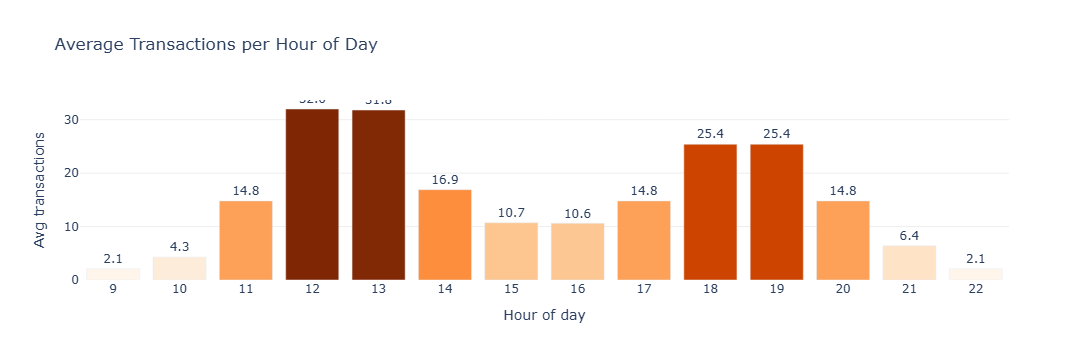

In [4]:
df_hourly = (
    df_txn.groupby('hour')['id']
    .count()
    .div(n_days)   # average per day
    .round(1)
    .reset_index(name='avg_transactions')
)

fig1 = px.bar(
    df_hourly,
    x='hour', y='avg_transactions',
    title='Average Transactions per Hour of Day',
    labels={'hour': 'Hour of day', 'avg_transactions': 'Avg transactions'},
    color='avg_transactions',
    color_continuous_scale='Oranges',
    text='avg_transactions',
)
fig1.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig1.update_layout(
    xaxis=dict(tickmode='linear', dtick=1),
    coloraxis_showscale=False,
    plot_bgcolor='white',
    yaxis=dict(gridcolor='#eee'),
)
fig1.show()

---
## Chart 2: Sales by Month (Seasonality)

Total revenue per month across both years. Expect summer peaks (terrace) and winter dips.

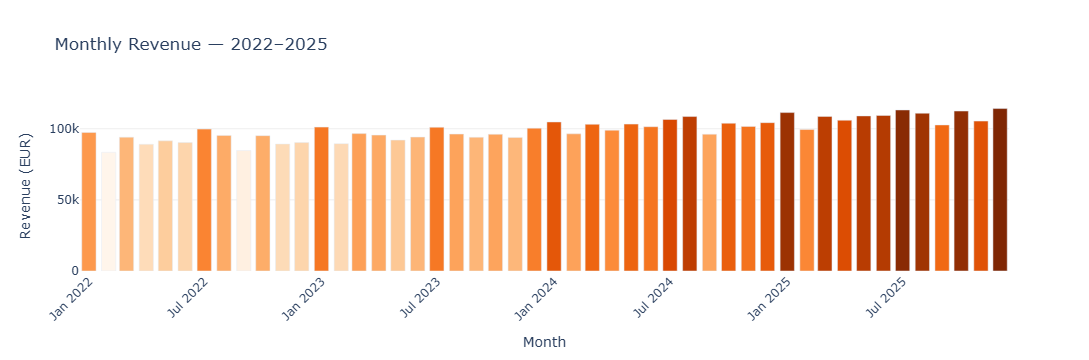

In [8]:
df_monthly = (
    df_txn.groupby('month')
    .agg(transactions=('id', 'count'), revenue=('total_amount', 'sum'))
    .reset_index()
)
df_monthly['revenue'] = df_monthly['revenue'].round(0)

fig2 = px.bar(
    df_monthly,
    x='month', y='revenue',
    title='Monthly Revenue — 2022–2025',
    labels={'month': 'Month', 'revenue': 'Revenue (EUR)'},
    color='revenue',
    color_continuous_scale='Oranges',
    text='revenue',
)
fig2.update_traces(texttemplate='€%{text:,.0f}', textposition='outside')
fig2.update_layout(
    xaxis_tickangle=-45,
    coloraxis_showscale=False,
    plot_bgcolor='white',
    yaxis=dict(gridcolor='#eee'),
    uniformtext_minsize=7,
    uniformtext_mode='hide',
)
fig2.show()

---
## Chart 3: Sales vs Temperature

Does warmer weather bring more customers?

- **Orange dots** = clear sky days
- **Blue dots** = rain, clouds, snow
- **Dashed line** = linear trend

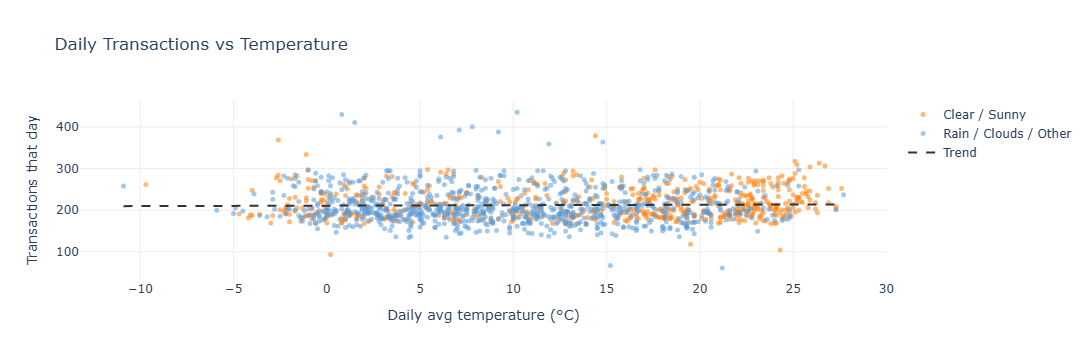

Trend: +0.1 transactions per °C increase in temperature


In [6]:
df_s = df_dw.dropna(subset=['temperature', 'conditions']).copy()
df_s['weather_group'] = df_s['conditions'].apply(
    lambda c: 'Clear / Sunny' if c == 'Clear' else 'Rain / Clouds / Other'
)

# Trendline via numpy (no extra dependency needed)
m, b = np.polyfit(df_s['temperature'], df_s['transactions'], 1)
x_range = np.array([df_s['temperature'].min(), df_s['temperature'].max()])
y_range = m * x_range + b

COLOR_MAP = {
    'Clear / Sunny':          '#FF7F0E',
    'Rain / Clouds / Other':  '#5B9BD5',
}

fig3 = go.Figure()

for group, color in COLOR_MAP.items():
    sub = df_s[df_s['weather_group'] == group]
    fig3.add_trace(go.Scatter(
        x=sub['temperature'], y=sub['transactions'],
        mode='markers', name=group,
        marker=dict(color=color, size=5, opacity=0.55),
        hovertemplate='%{x:.1f}°C — %{y} transactions<extra>' + group + '</extra>',
    ))

fig3.add_trace(go.Scatter(
    x=x_range.tolist(), y=y_range.tolist(),
    mode='lines', name='Trend',
    line=dict(color='#333', width=2, dash='dash'),
))

fig3.update_layout(
    title='Daily Transactions vs Temperature',
    xaxis_title='Daily avg temperature (°C)',
    yaxis_title='Transactions that day',
    plot_bgcolor='white',
    xaxis=dict(gridcolor='#eee'),
    yaxis=dict(gridcolor='#eee'),
)
fig3.show()

print(f'Trend: +{m:.1f} transactions per °C increase in temperature')

---
## Chart 4: Daily Bun Waste — The Problem We Are Solving

Every day, the restaurant over-orders buns by **8–12%**.

The waste is **consistent and predictable** — which means a simple predictive model can eliminate most of it.

> If we can predict tomorrow's burger sales, we know exactly how many buns to order.

Average daily bun waste:    8.9%
Total buns wasted (2 yrs):  47,095
Estimated cost @ €0.35/bun:  €16,483 over 4 years


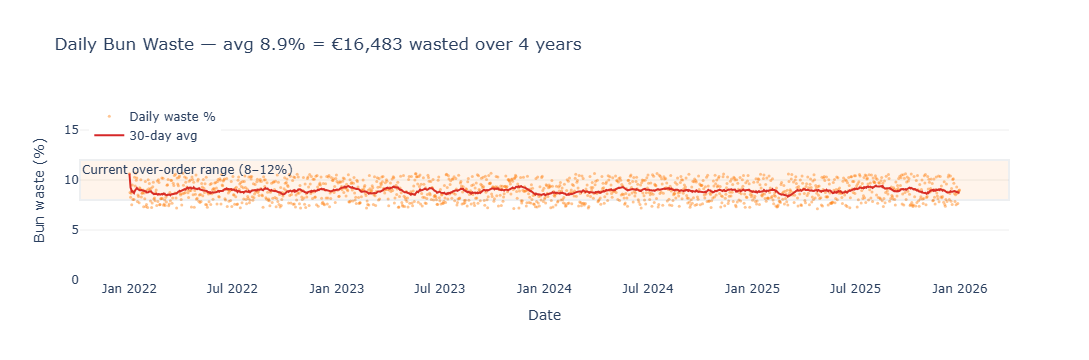

In [7]:
avg_waste   = df_buns['waste_percentage'].mean()
total_waste = (df_buns['ordered_buns'] - df_buns['actual_buns_used']).sum()
BUN_COST    = 0.35   # EUR per bun — adjust to real cost
waste_eur   = total_waste * BUN_COST

print(f'Average daily bun waste:    {avg_waste:.1f}%')
print(f'Total buns wasted (2 yrs):  {total_waste:,}')
print(f'Estimated cost @ €{BUN_COST}/bun:  €{waste_eur:,.0f} over 4 years')

# 30-day rolling average
df_buns['waste_30d'] = df_buns['waste_percentage'].rolling(30, min_periods=1).mean()

fig4 = go.Figure()

# Daily dots
fig4.add_trace(go.Scatter(
    x=df_buns['date'], y=df_buns['waste_percentage'],
    mode='markers', name='Daily waste %',
    marker=dict(color='#FF7F0E', size=3, opacity=0.45),
))

# 30-day rolling line
fig4.add_trace(go.Scatter(
    x=df_buns['date'], y=df_buns['waste_30d'],
    mode='lines', name='30-day avg',
    line=dict(color='#D62728', width=2),
))

# Reference band
fig4.add_hrect(y0=8, y1=12, fillcolor='#FF7F0E', opacity=0.08,
               annotation_text='Current over-order range (8–12%)',
               annotation_position='top left')

fig4.update_layout(
    title=(
        f'Daily Bun Waste — avg {avg_waste:.1f}%'
        f' = €{waste_eur:,.0f} wasted over 4 years'
    ),
    xaxis_title='Date',
    yaxis_title='Bun waste (%)',
    yaxis=dict(range=[0, 18], gridcolor='#eee'),
    plot_bgcolor='white',
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01),
)
fig4.show()

---
## Summary

| Finding | Observation |
|---------|-------------|
| Peak hours | 12h, 13h (lunch) and 18h, 19h (dinner) |
| Seasonality | Summer months highest revenue (terrace) |
| Weather effect | Warmer and sunnier → more customers |
| Bun waste | ~10% over-ordered every single day |

**Next step:** Build a predictive model — use day-of-week + weather forecast + calendar events
to predict tomorrow's burger sales and order exactly the right number of buns.